## Loading Data

In [1]:
import os
import ast
import typing
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import date, datetime

pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
os.makedirs('./bicing', exist_ok=True)

if not len(os.listdir('./bicing')):
    i2m = list(zip(range(1,13), months))
    for year in [2023, 2022, 2021, 2020, 2019]:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"mv '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv' './data' ")
            os.system(f"rm './data/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [5]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [8]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    new_df['percentage_docks_available'] = new_df['num_bikes_available'] / new_df['num_docks_available']

    return new_df

In [9]:
def get_df_processed(file_name_csv: str = 'df_processed.csv'):
    if os.path.exists(file_name_csv):
        return pd.read_csv(file_name_csv)
        
    for csv in tqdm(os.listdir('./bicing')):
        new_df = pd.read_csv('./bicing/' + csv)
        new_df = process_new_df(new_df)

        # Filter out incorrect dates
        year, month, *_ = csv.split('_')
        year, month = int(year), int(month)
        new_df = new_df[(new_df.year == year) & (new_df.month == month)]

        df = pd.concat(
            [df, new_df], 
            axis=0
        )
    
    df.to_csv(file_name_csv, index=False, header=True)
    return df

df = get_df_processed()

In [10]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [11]:
df.shape

(16368488, 21)

In [12]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0


### Add station information

In [13]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [14]:
station_json = get_station_json()

In [15]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [16]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [17]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,46
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [18]:
df = pd.merge(df, station_df)

In [19]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46


### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [20]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-03-28
End date:  2023-04-30


In [21]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [22]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [23]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [24]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [25]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [26]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [27]:
weather_df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,date
0,2019-03-28,16.8,6.4,12.1,16.8,3.7,11.5,4.4,60.6,0.0,0,0.0,0.0,0.0,21.5,17.3,42.8,1.1,16.1,221.4,19.2,7,NaN,Clear,clear-day,2019-03-28
1,2019-03-29,16.3,8.8,12.8,16.3,6.7,12.6,5.1,60.6,0.0,0,0.0,0.0,0.0,24.8,19.8,76.9,8.9,16.1,222.3,19.1,7,NaN,Clear,clear-day,2019-03-29
2,2019-03-30,16.0,6.4,12.0,16.0,4.2,11.6,5.8,66.0,0.0,0,0.0,0.0,0.0,24.3,19.1,79.9,29.4,15.5,224.5,19.6,7,NaN,Partially cloudy,partly-cloudy-day,2019-03-30
3,2019-03-31,15.9,8.4,12.5,15.9,6.9,12.4,7.9,73.5,0.0,0,0.0,0.0,0.0,37.6,31.2,71.2,50.3,14.7,154.2,12.8,6,NaN,Partially cloudy,partly-cloudy-day,2019-03-31
4,2019-04-01,17.3,9.8,13.8,17.3,9.0,13.7,6.1,60.7,0.0,0,0.0,0.0,0.0,23.4,18.1,126.5,35.0,15.3,214.7,18.6,7,NaN,Partially cloudy,partly-cloudy-day,2019-04-01


In [28]:
df.date = pd.to_datetime(df.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df = pd.merge(df, weather_df, left_on='date', right_on='date')

In [29]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.213033,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100,8.33,0.0,0.0,18.2,15.2,169.9,37.6,17.5,182.8,15.7,8,NaN,"Rain, Partially cloudy",rain
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.224839,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100,8.33,0.0,0.0,18.2,15.2,169.9,37.6,17.5,182.8,15.7,8,NaN,"Rain, Partially cloudy",rain
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.213793,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100,8.33,0.0,0.0,18.2,15.2,169.9,37.6,17.5,182.8,15.7,8,NaN,"Rain, Partially cloudy",rain
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100,8.33,0.0,0.0,18.2,15.2,169.9,37.6,17.5,182.8,15.7,8,NaN,"Rain, Partially cloudy",rain
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.222222,0.0,41.397978,2.180107,16.0,46,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100,8.33,0.0,0.0,18.2,15.2,169.9,37.6,17.5,182.8,15.7,8,NaN,"Rain, Partially cloudy",rain


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [30]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [31]:
covid_json = get_covid_json()

In [32]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [33]:
covid_df.shape

(773, 10)

In [34]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [35]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [36]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [37]:
covid_df.head()

,covid_cases,date
0,1,2020-02-25
1,0,2020-02-26
2,0,2020-02-27
3,0,2020-02-28
4,0,2020-02-29


In [38]:
df = pd.merge(
    df, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [39]:
df.covid_cases = df.covid_cases.astype('float')

In [40]:
df.covid_cases.describe()

count    8.598920e+06
mean     6.542431e+02
std      1.226903e+03
min      0.000000e+00
25%      9.000000e+01
50%      2.690000e+02
75%      5.800000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<AxesSubplot:>

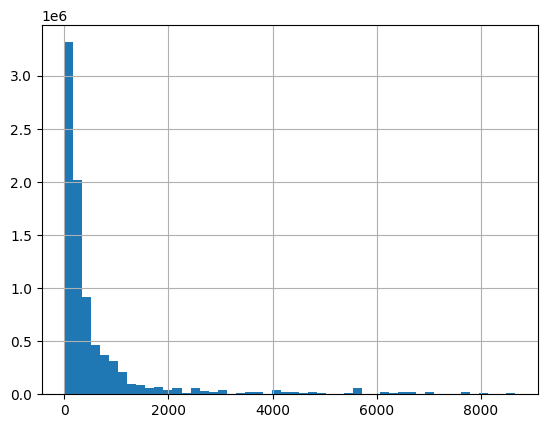

In [41]:
df.covid_cases.hist(bins=50)

In [42]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [43]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  6.0


We could add also information about in which dates the people where closed into their homes.

In [44]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [45]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [46]:
index_non_confinment = df[
    (df['date'] < confinment_date_start) |
    (df['date'] > confinment_date_end)
].index

In [47]:
    df.loc[index_non_confinment, 'confinment'] = 0
df['confinment'] = df['confinment'].fillna(1)
df['confinment'] = df['confinment'].astype('int')

### Barcelona Events

In [48]:
os.makedirs('./events', exist_ok=True)

In [49]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [50]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [51]:
events_df.head()

,register_id,prefix,suffix,name,created,modified,status,status_name,core_type,core_type_name,body,tickets_data,addresses,entity_types_data,attribute_categories,values,from_relationships,to_relationships,classifications_data,secondary_filters_data,timetable,image_data,gallery_data,warnings,geo_epgs_25831,geo_epgs_23031,geo_epgs_4326,is_section_of_data,sections_data,start_date,end_date,estimated_dates,languages_data,type,type_name,period,period_name,event_status_name,event_status,ical
0,99400525102,NaN,NaN,Taller per a gent gran 'Rutes històriques',2017-08-16T13:30:42+02:00,2023-05-05T09:25:29.185732+02:00,published,Publicat,event,Agenda,<p>Responsable: Laura Sancliment</p>,"[{'id': 4, 'name': 'Pagament'}]","[{'place': None, 'district_name': 'Gràcia', 'd...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 101733, 'value': 'http://ajuntament.ba...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2003, 'name': 'Cursos i tallers', 'ful...","[{'id': 400006, 'name': 'Cursos i tallers', 'f...","{'id': 21364, 'html': '<table class=""timetable...",NaN,[],[],"{'x': 430431.78075060085, 'y': 4584115.699037433}","{'x': 430526.3148355534, 'y': 4584320.274295482}","{'x': 41.40557651201225, 'y': 2.167687591797475}",NaN,NaN,2023-04-12T03:00:00+02:00,2023-06-21T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",unique,Puntual,NaN,NaN,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
1,99400429455,Campanya Vacances Estiu 2023,NaN,"Campus Olímpia Poliesportiu de futbol ""UE de S...",2016-03-21T13:48:45+01:00,2023-04-28T11:30:51.078276+02:00,published,Publicat,event,Agenda,"<p><br></p><p>Mitjantçant jocs esportius, inci...","[{'id': 4, 'name': 'Pagament'}]",[{'place': 'Complex Esportiu Municipal La Bàsc...,"[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 517883, 'value': 'https://preinscripci...","[{'type_id': 1002, 'name': 'se celebra a', 'en...","[{'id': 43452, 'order': 3, 'relationship_type'...","[{'id': 2000, 'name': 'Campus', 'full_path': '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 19661, 'html': '<table class=""timetable...",NaN,[],"[{'id': 10581, 'text': ""<p>Preinscripció a la ...","{'x': 428509.6025101154, 'y': 4579001.6205476}","{'x': 428604.17713829316, 'y': 4579206.179636406}","{'x': 41.35934723795843, 'y': 2.145296484485313}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-07-28T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
2,99400429539,Campanya Vacances Estiu 2023,NaN,Campus Olímpia Poliesportiu 'Esports de platja...,2016-03-22T11:31:06+01:00,2023-04-28T11:31:11.724531+02:00,published,Publicat,event,Agenda,<p>Casal esportiu especialitzat en surf i padd...,"[{'id': 4, 'name': 'Pagament'}]",[{'place': 'Instal·lació Esportiva Municipal E...,"[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 517860, 'value': 'https://preinscripci...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2000, 'name': 'Campus', 'full_path': '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 19674, 'html': '<table class=""timetable...",NaN,[],"[{'id': 4451, 'text': ""<p>Preinscripcions a la...","{'x': 432451.0057211068, 'y': 4581195.449937797}","{'x': 432545.5633644259, 'y': 4581400.0408440335}","{'x': 41.37944683668935, 'y': 2.192168912555447}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-09-01T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
3,99400468386,NaN,NaN,Exposició 'La Fabra i Coats abans i ara. Sínte...,2016-10-28T13:45:40+02:00,2021-04-16T19:49:56.691120+02:00,published,Publicat,event,Agenda,<p>La delegació de Sant Andreu del CNL de Barc...,"[{'id': 3, 'name': 'Lliure'}]","[{'place': N

In [52]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [53]:
def events_df_drop_columns(
    events_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
        'core_type', 'core_type_name',                                                                 # most is only one type of value
        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
    ]
):
    
    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [54]:
# Drop columns not wanted
events_df = events_df_drop_columns(events_df)

In [55]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [56]:
events_df.head()

,geo_epgs_4326,start_date,end_date
0,"{'x': 41.40557651201225, 'y': 2.167687591797475}",2023-04-12T03:00:00+02:00,2023-06-21T03:00:00+02:00
1,"{'x': 41.35934723795843, 'y': 2.145296484485313}",2023-06-26T03:00:00+02:00,2023-07-28T03:00:00+02:00
2,"{'x': 41.37944683668935, 'y': 2.192168912555447}",2023-06-26T03:00:00+02:00,2023-09-01T03:00:00+02:00
3,"{'x': 41.433793974354174, 'y': 2.1908326284827...",2016-10-03T00:00:00+02:00,NaN
4,"{'x': 41.38494355675254, 'y': 2.18032338969291}",2016-10-07T00:00:00+02:00,NaN


In [57]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [58]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(x))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [59]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [60]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

In [61]:
# Filter out by maximum and minimum dates of df
df_min_date, df_max_date = df.date.min(), df.date.max()

events_df = events_df[events_df.start_date > df_min_date]
events_df = events_df[events_df.end_date < df_max_date]

In [62]:
events_df

,start_date,end_date,x,y
47,2020-03-22,2020-03-22,41.395348,2.162061
64,2023-01-19,2023-01-19,41.395348,2.162061
94,2020-07-08,2020-07-08,41.384205,2.176957
95,2020-07-08,2020-07-08,41.384205,2.176957
100,2019-07-24,2019-07-24,41.413298,2.130676
...,...,...,...,...
2815,2021-10-18,2021-10-18,41.398138,2.205365
2879,2022-11-05,2022-11-05,41.396003,2.190205
3149,2022-02-01,2022-02-01,41.352263,2.142380
3226,2022-02-10,2022-02-10,41.372918,2.136698


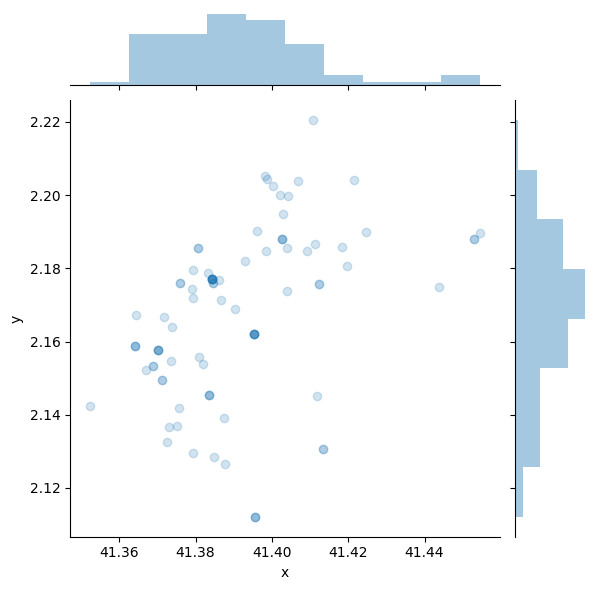

In [63]:
sns.jointplot(x="x", y="y", data=events_df, alpha=0.2)

In [64]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [65]:
# Join this information with the main df

In [66]:
df.date.dtype

dtype('O')

In [67]:
1 + None

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [ ]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [pd.merge(df, events_df, left_on='date', right_on='start_date'),
    pd.merge(df, events_df, left_on='date', right_on='end_date')],
    axis=0
).drop_duplicates()

In [ ]:
df_common_events.head()

In [ ]:
for idx, row in tqdm(events_df.iterrows()):    
    start_date, end_date = row['start_date'], row['end_date']
    range_dates = pd.date_range(start_date, end_date)
    
    range_df = df[df.date.isin(range_dates)]
    if len(range_df) > 0:
        print('here')
    

In [ ]:
range_dates

In [ ]:
df.head()

In [ ]:
df[(df.year == 2020) & (df.month == 6) & (df.day == 1)]

In [ ]:
range_df

In [ ]:
events_df

In [ ]:

std_dev_x * 0.2

In [ ]:
events_df.x.describe()

In [ ]:
df

In [ ]:
# Checkpoint of the extended df with external sources
df.to_csv('df_extended.gzip', index=False, header=True, compression='gzip')

### Datetime Information

In [ ]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [ ]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [ ]:
df['day_info'] = df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [ ]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [ ]:
df['hour_info'] = df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [ ]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [ ]:
df['month_info'] = df.date_time.apply(lambda x: get_month_info(x))

In [ ]:
df.head()

### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [ ]:
df = df.sort_values(['station_id', 'date_time'], ascending=True)

In [ ]:
df_shifted = pd.DataFrame()

In [ ]:
for station_id in tqdm(df.station_id.unique()):
    station_df = df[df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)
    

In [ ]:
df_shifted.head()

### Train / Val / Test Split

In [ ]:
df_shifted.head()

In [ ]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [ ]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

In [ ]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

### Exploration